In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [25]:
print(len(training_data))
print(len(test_data))

60000
10000


In [7]:
from torch.utils.data import DataLoader
test_loader=DataLoader(test_data, batch_size=64,shuffle=True)

In [8]:
from sklearn.metrics import f1_score, confusion_matrix

input_size=28
sequence_length=28
hidden_size=256
num_classes=10

In [40]:
import torch.nn as nn
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.rnn=nn.GRU(input_size, hidden_size, bidirectional=True)
        self.linear2=nn.Linear(2*hidden_size,output_size)
    
    def forward(self,x):
        x=x.permute(1,0,2)
        hidden=torch.zeros(2,x.shape[1],self.hidden_size).to(device)
        state,_=self.rnn(x,hidden)
        output=self.linear2(state[-1])
        return output

In [41]:
model=BRNN(input_size, hidden_size, num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer=torch.optim.Adam(model.parameters())
loss=nn.CrossEntropyLoss()
model.to(device)

BRNN(
  (rnn): GRU(28, 256, bidirectional=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)

In [42]:
def train(model,training_data,optim,loss,epoch=5):
    for ep in range(epoch):
        train_data, val_data = torch.utils.data.random_split(training_data, [50000, 10000])
        train_loader=DataLoader(train_data, batch_size=64)
        val_loader=DataLoader(val_data, batch_size=64)
        model.train()
        train_output=[]
        train_true=[]
        for i,data in enumerate(train_loader):
            x,y = data
            x=x.squeeze()
            x=x.to(device)
            y=y.to(device)
            output=model(x)
            l=loss(output,y)
            optim.zero_grad()
            l.backward()
            optim.step()
            train_output.extend(torch.max(output,1)[1].tolist())
            train_true.extend(y.tolist())
        val_output=[]
        val_true=[]
        with torch.no_grad():
            model.eval()
            for i,data in enumerate(val_loader):
                x,y = data
                x=x.squeeze()
                x=x.to(device)
                y=y.to(device)
                output=model(x)
                val_output.extend(torch.max(output, 1)[1].tolist())
                val_true.extend(y.tolist())
        print(f'epoch {ep+1} |  train f1 {round(f1_score(train_true, train_output, average="macro"),4)} |  val f1 {round(f1_score(val_output, val_true, average="macro"),4)}')

In [44]:
train(model,training_data,optimizer,loss,epoch=10)

epoch 1 |  train f1 0.8921 |  val f1 0.8974
epoch 2 |  train f1 0.8978 |  val f1 0.8992
epoch 3 |  train f1 0.9031 |  val f1 0.9053
epoch 4 |  train f1 0.9091 |  val f1 0.9115
epoch 5 |  train f1 0.9123 |  val f1 0.9176
epoch 6 |  train f1 0.9171 |  val f1 0.9135
epoch 7 |  train f1 0.9206 |  val f1 0.9227
epoch 8 |  train f1 0.925 |  val f1 0.9243
epoch 9 |  train f1 0.9287 |  val f1 0.9283
epoch 10 |  train f1 0.9328 |  val f1 0.9276


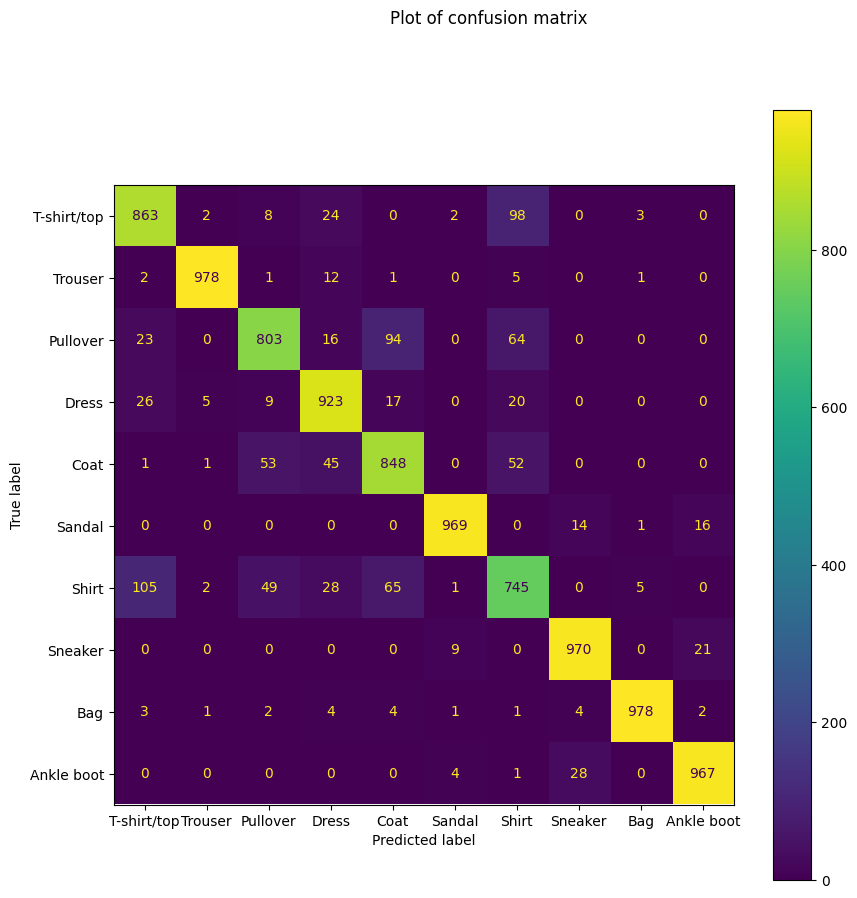

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
def test(model,test_data):
    test_output=[]
    test_true=[]
    with torch.no_grad():
        model.eval()
        for i,data in enumerate(test_data):
            x,y = data
            x=x.squeeze()
            x=x.to(device)
            y=y.to(device)
            output=model(x)
            test_output.extend(torch.max(output, 1)[1].tolist())
            test_true.extend(y.tolist())
    disp = ConfusionMatrixDisplay.from_predictions(test_true, test_output, display_labels=class_names)
    fig = disp.figure_
    fig.set_figwidth(10)
    fig.set_figheight(10) 
    fig.suptitle('Plot of confusion matrix')
test(model, test_loader)